<a href="https://colab.research.google.com/github/mangelpg/AA.ipynb/blob/main/T3_SVMHyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install scikit-learn==0.24.2
!pip install scikit-optimize
#!pip install --user git+https://github.com/scikit-optimize/scikit-optimize.git

In [ ]:
# Checking that everything is correct with skopt (0.9.dev0) and sklearn 
from skopt import __version__
print(__version__)
from sklearn import __version__
print(__version__)

# SVM lineal
En *Scikit Learn* pueden encontrarse tres implementaciones distintas del algoritmo Suport Vector Machine:
*   Las clases `sklearn.svm.SVC` y `sklearn.svm.NuSVC` permiten crear modelos SVM de clasificación empleando kernel lineal, polinomial, radial o sigmoide. La diferencia es que `SVC` controla la regularización a través del hiperparámetro `C`, mientras que `NuSVC` lo hace con el número máximo de vectores soporte permitidos.
*  La clase `sklearn.svm.LinearSVC` permite ajustar modelos SVM con kernel lineal. Es similar a SVC cuando el parámetro `kernel='linear'`, pero utiliza un algoritmo más rápido. 

Las mismas implementaciones están disponibles para regresión en las clases: `sklearn.svm.SVR`, `sklearn.svm.NuSVR` y `sklearn.svm.LinearSVR`.

Se ajusta primero un modelo SVM con kernel lineal y después uno con kernel radial, y se compara la capacidad de cada uno para clasificar correctamente las observaciones.

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Preprocesado y modelado
# ==============================================================================
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Datos
# ==============================================================================
datos = pd.read_csv('/content/drive/MyDrive/Docencia/AprendizajeAutomatico/2022-2023/Tutoriales sklearn/SVM.csv')
datos.head(3)

,X1,X2,y
0,2.526093,0.321050,0
1,0.366954,0.031462,0
2,0.768219,0.717486,0


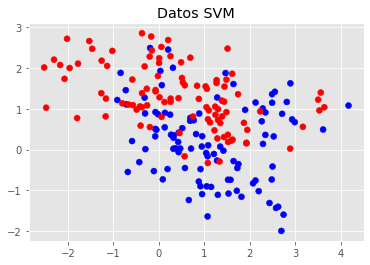

In [4]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(datos.X1, datos.X2, c=datos.y);
ax.set_title("Datos SVM");

In [5]:
# División de los datos en train y test
# ==============================================================================
X = datos.drop(columns = 'y')
y = datos['y']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle      = True
                                    )

In [6]:
# Creación del modelo SVM lineal
# ==============================================================================
modelo = SVC(C = 100, kernel = 'linear', random_state=42)
modelo.fit(X_train, y_train)

SVC(C=100, kernel='linear', random_state=42)

Al tratarse de un problema de dos dimensiones, se puede representar las regiones de clasificación.

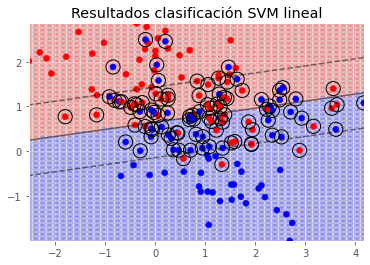

In [7]:
# Representación gráfica de los límites de clasificación
# ==============================================================================
# Grid de valores
x = np.linspace(np.min(X_train.X1), np.max(X_train.X1), 50)
y = np.linspace(np.min(X_train.X2), np.max(X_train.X2), 50)
Y, X = np.meshgrid(y, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

# Predicción valores grid
pred_grid = modelo.predict(grid)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(grid[:,0], grid[:,1], c=pred_grid, alpha = 0.2)
ax.scatter(X_train.X1, X_train.X2, c=y_train, alpha = 1)

# Vectores soporte
ax.scatter(
    modelo.support_vectors_[:, 0],
    modelo.support_vectors_[:, 1],
    s=200, linewidth=1,
    facecolors='none', edgecolors='black'
)

# Hiperplano de separación
ax.contour(
    X,
    Y,
    modelo.decision_function(grid).reshape(X.shape),
    colors = 'k',
    levels = [-1, 0, 1],
    alpha  = 0.5,
    linestyles = ['--', '-', '--']
)

ax.set_title("Resultados clasificación SVM lineal");

Se calcula el porcentaje de aciertos que tiene el modelo al predecir las observaciones de test (accuracy).

In [8]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X_test)
predicciones

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [9]:
# Accuracy de test del modelo 
# ==============================================================================
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 72.5%


# SVM radial
Se repite el ajuste del modelo, esta vez empleando un kernel radial y utilizando validación cruzada para identificar el valor óptimo de penalización `C`

In [10]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 7, 20)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = SVC(kernel= "rbf", gamma='scale'),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
12,379.269019,0.825181,0.043594,0.875037,0.017379
10,20.691381,0.812835,0.092814,0.834421,0.043227
11,88.586679,0.806429,0.072225,0.853142,0.038341
14,6951.927962,0.793967,0.024542,0.903221,0.026560
9,4.83293,0.793967,0.110597,0.815670,0.028613


In [11]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 379.2690190732246} : 0.8251805264383881 accuracy


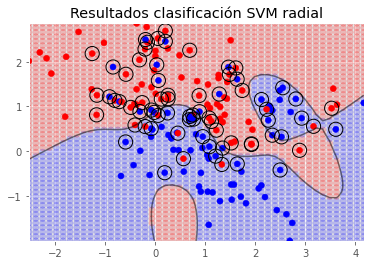

In [12]:
# Representación gráfica de los límites de clasificación
# ==============================================================================
# Grid de valores
x = np.linspace(np.min(X_train.X1), np.max(X_train.X1), 50)
y = np.linspace(np.min(X_train.X2), np.max(X_train.X2), 50)
Y, X = np.meshgrid(y, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

# Predicción valores grid
pred_grid = modelo.predict(grid)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(grid[:,0], grid[:,1], c=pred_grid, alpha = 0.2)
ax.scatter(X_train.X1, X_train.X2, c=y_train, alpha = 1)

# Vectores soporte
ax.scatter(
    modelo.support_vectors_[:, 0],
    modelo.support_vectors_[:, 1],
    s=200, linewidth=1,
    facecolors='none', edgecolors='black'
)

# Hiperplano de separación
ax.contour(
    X,
    Y,
    modelo.decision_function(grid).reshape(X.shape),
    colors='k',
    levels=[0],
    alpha=0.5,
    linestyles='-'
)

ax.set_title("Resultados clasificación SVM radial");

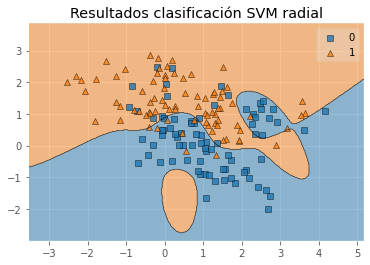

In [13]:
# Representación gráfica utilizando plot_decision_regions() de mlxtend
# ==============================================================================
fig, ax = plt.subplots(figsize=(6,4))
plot_decision_regions(
    X = X_train.to_numpy(),
    y = y_train.flatten(),
    clf = modelo,
    ax = ax
)
ax.set_title("Resultados clasificación SVM radial");

In [14]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X_test)

In [15]:
# Accuracy de test del modelo 
# ==============================================================================
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 80.0%


In [16]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    predicciones,
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

Predicción,0,1
Real,,
0,14,7
1,1,18


Con un modelo SVM de kernel radial se consigue clasificar correctamente el 80% de las observaciones de test. Se podría intentar mejorar aún más el modelo optimizando el valor del hiperparámetro gamma o utilizando otro tipo de kernel.

# SVM HYPER-PARAMETER TUNING

- `C` : float, default=1.0
Parámetro de regularización. La fuerza de la regularización es inversamente proporcional a C. Debe ser estrictamente positivo.
    
- `gamma` : float, coeficiente para el Kernel `rbf`


- Hay más hiperparámetros, pero estos dos son los importantes: 
  - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
  - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html



Primero, se cargan los datos, las entradas van a X, las salidas a y.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
from scipy.stats import sem

boston = load_boston()
X = boston.data
y = boston.target

## COMBINAR EL AJUSTE DE HIPERPARÁMETROS Y LA EVALUACIÓN DE MODELOS

La combinación de evaluación de modelos y ajuste de hiperparámetros puede entenderse como un bucle externo (outer) que entrena un modelo y prueba el modelo, y un bucle interno (inner), donde el proceso de entrenamiento consiste en buscar los mejores hiperparámetros, y luego obtener el modelo con esos mejores hiperparámetros.

En primer lugar, vamos a utilizar **Holdout** (entrenar/probar) para la evaluación del modelo (bucle externo o **outer**), y **3-fold crossvalidation** para el ajuste de los hiperparámetros (bucle interno o **inner**). Los hiperparámetros se ajustarán con **Gridsearch**.


#### GRIDSEARCH

En primer lugar, definamos nuestra función python para el RMSE

In [18]:
def rmse(y_test, y_test_pred):
  """ This is my computation of Root Mean Squared Error """
  return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

In [19]:
from sklearn.model_selection import train_test_split

# Holdout for model evaluation. 33% of available data for test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)

En primer lugar, recordemos el RMSE con hiperparámetros por defecto

In [20]:
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# This is the preprocessing pipeline: SVMs need scaling
scaler = StandardScaler()
svr = SVR()

pipe_regr = Pipeline([
    ('scale', scaler),
    ('SVM', svr)])

np.random.seed(42)
pipe_regr.fit(X=X_train, y=y_train)
print(f"RMSE of SVR with default hyper-pars: {rmse(y_test, pipe_regr.predict(X=X_test))}")


RMSE of SVR with default hyper-pars: 5.272094215452437


In [23]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import KFold


# Search space
param_grid = {'SVM__C': [0.1, 1, 10, 100],
              'SVM__gamma': [0.01, 0.1, 1]}

# Other search space

inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Definition of a 2-step process that self-adjusts 2 hyperpars
hpo_regr = GridSearchCV(pipe_regr, 
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=inner, 
                        n_jobs=4, verbose=1)

# Train the self-adjusting process
np.random.seed(42)
hpo_regr.fit(X=X_train, y=y_train)

# At this point, regr contains the model with the best hyper-parameters found by gridsearch
# and trained on the complete X_train

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('SVM', SVR())]),
             n_jobs=4,
             param_grid={'SVM__C': [0.1, 1, 10, 100],
                         'SVM__gamma': [0.01, 0.1, 1]},
             scoring='neg_mean_squared_error', verbose=1)

Visualicemos:
- Los mejores hiperparámetros y su puntuación (¡inner!). 
- La evaluación del modelo (¡outer!) con los datos de test y los mejores hiperparámetros.



In [24]:
print(f"Best params: {hpo_regr.best_params_}, best score (inner!): {np.sqrt(-hpo_regr.best_score_)}")
# Now, the performance of regr is computed on the test partition
print(f"RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): {rmse(y_test, hpo_regr.predict(X=X_test))}")

Best params: {'SVM__C': 100, 'SVM__gamma': 0.1}, best score (inner!): 4.01405025119901
RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): 3.865893117390892


Observamos que el mejor valor de C es 100, que está en el límite del espacio de búsqueda. Podemos plantearnos ampliar el espacio de búsqueda y ver si mejoran los resultados.

In [29]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import KFold


# Search space
param_grid = {'SVM__C': [0.1, 1, 10, 100, 1000, 10000],
              'SVM__gamma': [0.01, 0.1, 1]}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Definition of a 2-step process that self-adjusts 2 hyperpars
hpo_regr = GridSearchCV(pipe_regr, 
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=inner, 
                        n_jobs=4, verbose=1)

# Train the self-adjusting process
np.random.seed(42)
hpo_regr.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


KeyboardInterrupt: ignored

In [26]:
print(f"Best params: {hpo_regr.best_params_}, best score (inner!): {np.sqrt(-hpo_regr.best_score_)}")
# Now, the performance of regr is computed on the test partition
print(f"RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): {rmse(y_test, hpo_regr.predict(X=X_test))}")

Best params: {'SVM__C': 1000, 'SVM__gamma': 0.01}, best score (inner!): 3.959700228146983
RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): 3.3137140751183622


Ahora bien, quizá valores gamma inferiores a 0,01 podrían ser mejores. Volvamos a ampliar el espacio.

In [27]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import KFold


# Search space
param_grid = {'SVM__C': [0.1, 1, 10, 100, 1000, 10000],
              'SVM__gamma': [0.0001, 0.001, 0.01, 0.1, 1]}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Definition of a 2-step process that self-adjusts 2 hyperpars
hpo_regr = GridSearchCV(pipe_regr, 
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=inner, 
                        n_jobs=4, verbose=1)

# Train the self-adjusting process
np.random.seed(42)
hpo_regr.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('SVM', SVR())]),
             n_jobs=4,
             param_grid={'SVM__C': [0.1, 1, 10, 100, 1000, 10000],
                         'SVM__gamma': [0.0001, 0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [28]:
print(f"Best params: {hpo_regr.best_params_}, best score (inner!): {np.sqrt(-hpo_regr.best_score_)}")
# Now, the performance of regr is computed on the test partition
print(f"RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): {rmse(y_test, hpo_regr.predict(X=X_test))}")

Best params: {'SVM__C': 1000, 'SVM__gamma': 0.01}, best score (inner!): 3.959700228146983
RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): 3.3137140751183622


#### RANDOMIZED SEARCH

Ahora, vamos a utilizar **Randomized Search** en lugar de gridsearch. Sólo se probarán 20 combinaciones de valores de hiperparámetros (budget=20)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# This is the preprocessing pipeline: SVMs need scaling
scaler = StandardScaler()
svr = SVR()

pipe_regr = Pipeline([
    ('scale', scaler),
    ('SVM', svr)])

# Search space
param_grid = {'SVM__C': [0.1, 1, 10, 100, 1000, 10000],
              'SVM__gamma': [0.0001, 0.001, 0.01, 0.1, 1]}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Train the self-adjusting process
np.random.seed(42)
hpo_regr.fit(X=X_train, y=y_train)

budget = 20 # out of 30 possibilities
hpo_regr = RandomizedSearchCV(pipe_regr, 
                            param_grid,
                            scoring='neg_mean_squared_error',
                            cv=inner, 
                            n_jobs=4, verbose=1,
                            n_iter=budget
                        )
np.random.seed(42)
hpo_regr.fit(X=X_train, y=y_train)

In [ ]:
print(f"Best params: {hpo_regr.best_params_}, best score (inner!): {np.sqrt(-hpo_regr.best_score_)}")
# Now, the performance of regr is computed on the test partition
print(f"RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): {rmse(y_test, hpo_regr.predict(X=X_test))}")

Hemos obtenido los mismos resultados, pero explorando menos posibilidades que con grid-search.

Para **Randomized Search**, podemos definir el espacio de búsqueda con distribuciones estadísticas, en lugar de utilizar valores particulares como hacíamos antes. A continuación puedes ver cómo utilizar una distribución `loguniform`.


In [30]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.fixes import loguniform

# This is the preprocessing pipeline: SVMs need scaling
scaler = StandardScaler()
svr = SVR()

pipe_regr = Pipeline([
    ('scale', scaler),
    ('SVM', svr)])

# Search space
# [0.1, 1, 10, 100, 1000, 10000]
# [0.0001, 0.001, 0.01, 0.1, 1]
param_grid = {'SVM__C': loguniform(1e-1, 1e4),
              'SVM__gamma': loguniform(1e-4, 1e0)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Train the self-adjusting process
np.random.seed(42)
hpo_regr.fit(X=X_train, y=y_train)

budget = 20 
hpo_regr = RandomizedSearchCV(pipe_regr, 
                            param_grid,
                            scoring='neg_mean_squared_error',
                            cv=inner, 
                            n_jobs=4, verbose=0,
                            n_iter=budget
                        )
np.random.seed(42)
hpo_regr.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scale', StandardScaler()),
                                             ('SVM', SVR())]),
                   n_iter=20, n_jobs=4,
                   param_distributions={'SVM__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4e3b6c5790>,
                                        'SVM__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4e3b877730>},
                   scoring='neg_mean_squared_error')

In [31]:
print(f"Best params: {hpo_regr.best_params_}, best score (inner!): {np.sqrt(-hpo_regr.best_score_)}")
# Now, the performance of regr is computed on the test partition
print(f"RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): {rmse(y_test, hpo_regr.predict(X=X_test))}")

Best params: {'SVM__C': 457.0563099801452, 'SVM__gamma': 0.024810409748678097}, best score (inner!): 3.75640423163029
RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): 3.3728322725574738


#### OBTENCIÓN DEL MODELO FINAL (PARA SU DESPLIEGUE, O PARA ENVIARLO A UN CONCURSO, ...)

Si al final, necesitamos un modelo final, podemos obtenerlo entrenando `hpo_regr` a todos los datos disponibles. Recordemos que `hpo_regr` realiza el ajuste de hiperparámetros.

In [ ]:
np.random.seed(42)

# Fitting again the randomized search HPO
regrFinal = hpo_regr.fit(X,y)

In [ ]:
regrFinal.best_params_, np.sqrt(-regrFinal.best_score_)

#### MODEL BASED OPTIMIZATION (BAYESIAN OPTIMIZATION)

Para ello se utilizará scikit-optimize (`skopt`): https://scikit-optimize.github.io. **Holdout** para la evaluación del modelo y **3-fold crossvalidation** para el ajuste de hiperparámetros (con **Model Based Optimization** ).


In [33]:
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-gxstxcdb
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-gxstxcdb
  Resolved https://github.com/scikit-optimize/scikit-optimize.git to commit a2369ddbc332d16d8ff173b12404b03fea472492
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=100268 sha256=9c5bfefbfb7ca151f7ceb8d85d2a86a88ce5be51b435d7a5c0ae3160354e1a6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-fd1nz0h4/wheels/40/48/e7/8f8bf2b4c2c847051cfaac9d3603002e5109468805dcc72b3a
Successfully built scikit-optimize


In [34]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.fixes import loguniform
from skopt import BayesSearchCV
from skopt.space import Real

# This is the preprocessing pipeline: SVMs need scaling
scaler = StandardScaler()
svr = SVR()

pipe_regr = Pipeline([
    ('scale', scaler),
    ('SVM', svr)])

# Search space
# [0.1, 1, 10, 100, 1000, 10000]
# [0.0001, 0.001, 0.01, 0.1, 1]
#param_grid = {'SVM__C': Real(1e-1, 1e4, prior="loguniform"),
param_grid = {'SVM__C': Real(1e-1, 1e4, prior="log-uniform"),
              'SVM__gamma': Real(1e-4, 1e0, prior="log-uniform")}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Train the self-adjusting process
np.random.seed(42)
hpo_regr.fit(X=X_train, y=y_train)

budget = 20
hpo_regr = BayesSearchCV(pipe_regr, 
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=inner, 
                        n_jobs=4, verbose=0,
                        n_iter=budget
                        )
np.random.seed(42)
hpo_regr.fit(X=X_train, y=y_train)

BayesSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('scale', StandardScaler()),
                                        ('SVM', SVR())]),
              n_iter=20, n_jobs=4, scoring='neg_mean_squared_error',
              search_spaces={'SVM__C': Real(low=0.1, high=10000.0, prior='log-uniform', transform='normalize'),
                             'SVM__gamma': Real(low=0.0001, high=1.0, prior='log-uniform', transform='normalize')})

In [35]:
print(f"Best params: {hpo_regr.best_params_}, best score (inner!): {np.sqrt(-hpo_regr.best_score_)}")
# Now, the performance of regr is computed on the test partition
print(f"RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): {rmse(y_test, hpo_regr.predict(X=X_test))}")

Best params: OrderedDict([('SVM__C', 280.7630339912492), ('SVM__gamma', 0.03825484634650064)]), best score (inner!): 3.717100385205383
RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): 3.4478304686644123


Podemos comprobar si la optimización ha convergido

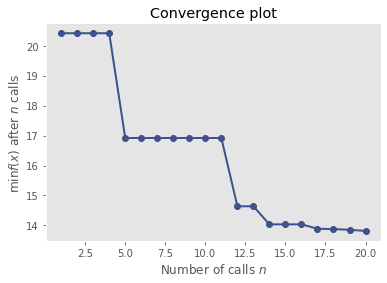

In [36]:
from skopt.plots import plot_convergence

_ = plot_convergence(hpo_regr.optimizer_results_[0])
plt.show()

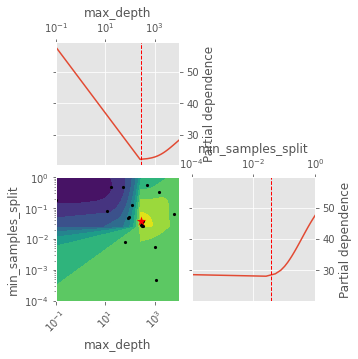

In [37]:
from skopt.plots import plot_objective

_ = plot_objective(hpo_regr.optimizer_results_[0],
                   dimensions=['C', 'alpha'],
                   n_minimum_search=int(1e8))
plt.show()